In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import sklearn as skl
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [3]:
train_df = pd.read_csv("titanic_train.csv")
test_df = pd.read_csv("titanic_test.csv")
data_cleaner = [train_df, test_df] # Create list of DF's to update train/test @ the same time
#take a look at the training data
sub = test_df['PassengerId'] # Passenger ID column that will be used in output file

In [4]:
train_df.describe(include="all") #Summary stats for DataFrame

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


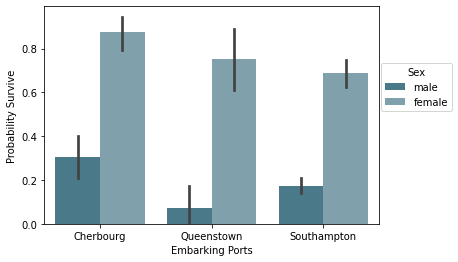

In [5]:
pal = sns.diverging_palette(220, 20, n=7)
 
ax = sns.barplot(x=train_df["Embarked"], y=train_df["Survived"], palette=pal,order=['C','Q','S'],hue=train_df["Sex"])
ax.set(xlabel='Embarking Ports', ylabel='Probability Survive')

ax.set_xticklabels(['Cherbourg', 'Queenstown', 'Southampton'])
plt.legend(bbox_to_anchor=(1.08, 0.7),
           bbox_transform=plt.gcf().transFigure,title="Sex", fancybox=True)

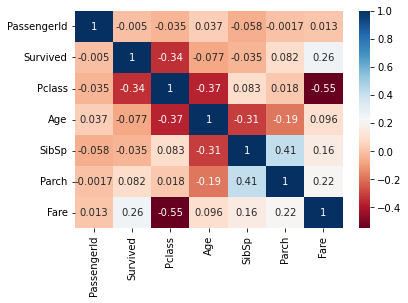

In [6]:
#### create a correlation graph of the different fields against the survival field
corr = train_df.corr()
sns.heatmap(corr, cmap = 'RdBu', annot = True, xticklabels = corr.columns.values,yticklabels = corr.columns.values)
plt.show()

In [7]:
# Null's in training/testing sets
for data in data_cleaner:
    print(data.isnull().sum())
    print('\n')

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64




In [8]:
# Get the average age for each Pclass
age_ref = pd.DataFrame(data=[train_df.groupby('Pclass')['Age'].mean()],columns=train_df['Pclass'].unique())
age_ref

,3,1,2
Age,25.14062,38.233441,29.87763


In [9]:
# Fill in null values for Age with average age for each Pclass based on the persons Pclass 
def fill_age(pclass,age):

    if pd.isnull(age):
        return float(age_ref[pclass])
    else:
        return age

for data in data_cleaner:
    data['Age'] = train_df.apply(lambda x: fill_age(x['Pclass'],x['Age']), axis=1)   

In [10]:
# If Fare is Null then replace with the average Fare
def fill_fare(fare):
    if pd.isnull(fare):
        return train_df['Fare'].mean()
    else:
        return fare

# If Embark is Null then replace with the average Embark
def fill_embark(embark):
    if pd.isnull(embark):
        return train_df['Embarked'].mode().iloc[0]
    else:
        return embark

# Use the 2 functions above to replace Nulls in Fare and Embarked columns
for data in data_cleaner:
    data['Fare'] = train_df.apply(lambda x: fill_fare(x['Fare']), axis=1)
    data['Embarked'] = train_df.apply(lambda x: fill_embark(x['Embarked']), axis=1)

In [11]:
# Drop column Cabin in both training and Test Set's
for data in data_cleaner:
    data.drop(['Cabin'],axis=1,inplace=True)

In [12]:
 #Create a title column using the Name field for Mr, Mrs, and Miss
title_list = list()
for data in data_cleaner:
    for title in data['Name']:
        title = title.split('.')[0].split(',')[1]
        title_list.append(title)
    
    data['Title'] = title_list
    title_list = list()

In [13]:
#replacing all titles with mr, mrs, miss
def replace_titles(x):
    title=x['Title']
    if title in [' Don', ' Major', ' Capt', ' Jonkheer', ' Rev', ' Col', ' Sir',' Master']:
        return 'Mr'
    elif title in [' the Countess', ' Mme',' Lady']:
        return 'Mrs'
    elif title in [' Mlle', ' Ms', 'Dona']:
        return 'Miss'
    elif title ==' Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title.replace(" ", "")
train_df['Title']=train_df.apply(replace_titles, axis=1)
test_df['Title'] = test_df.apply(replace_titles, axis = 1)

In [14]:
# Get the family size using # of parents and children columns
def get_size(df):
    if df['SibSp'] + df['Parch'] + 1 == 1:
        return 'Single'
    if df['SibSp'] + df['Parch'] + 1 > 1:
        return 'Small'
    if df['SibSp'] + df['Parch'] + 1 > 4:
        return 'Big'
    
for data in data_cleaner:
    data['FamilySize'] = data.apply(get_size,axis=1)

# Also create an IsAlone column using family size of single
for data in data_cleaner:
    data['IsAlone'] = 1 
    data['IsAlone'].loc[data['FamilySize'] != 'Single'] = 0

C:\Users\KIIT\AppData\Local\Temp\ipykernel_18612\3626888375.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['IsAlone'].loc[data['FamilySize'] != 'Single'] = 0
C:\Users\KIIT\AppData\Local\Temp\ipykernel_18612\3626888375.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['IsAlone'].loc[data['FamilySize'] != 'Single'] = 0


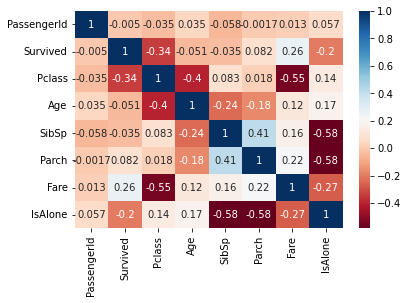

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,Small,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,Small,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,Single,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,Small,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,Single,1


In [15]:
#### create a correlation graph of the different fields against the survival field
corr = train_df.corr()
sns.heatmap(corr, cmap = 'RdBu', annot = True, xticklabels = corr.columns.values,yticklabels = corr.columns.values)
plt.show()
train_df.head()

In [16]:
# create initializations of old tables
train_df2 = train_df
test_df2 = test_df
train_df3 = train_df2
test_df3 = test_df2

# Create dummy variables for some of the features
sex = pd.get_dummies(train_df['Sex'],drop_first=True)
embark = pd.get_dummies(train_df['Embarked'],drop_first=True)
title = pd.get_dummies(train_df['Title'],drop_first=True)
Pclass = pd.get_dummies(train_df['Pclass'],drop_first=True)
FamilySize = pd.get_dummies(train_df['FamilySize'],drop_first=True)

sex2 = pd.get_dummies(test_df['Sex'],drop_first=True)
embark2 = pd.get_dummies(test_df['Embarked'],drop_first=True)
title2 = pd.get_dummies(test_df['Title'],drop_first=True)
Pclass2 = pd.get_dummies(test_df['Pclass'],drop_first=True)
FamilySize2 = pd.get_dummies(test_df['FamilySize'],drop_first=True)

for data in data_cleaner:
    data.drop(['Sex','Embarked','Name','Ticket','PassengerId','Title','Pclass','FamilySize'],axis=1,inplace=True)
    
train_df = pd.concat([sex,embark,train_df,title,FamilySize,Pclass],axis=1)
test_df = pd.concat([sex2,embark2,test_df,title2,FamilySize2,Pclass2],axis=1)

In [17]:
 #Import some new packages for Logistic Regression and K-Fold Cross Validation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc

# Initialize X and Y variables for training and X variable for Test
X = train_df.drop('Survived',axis=1)
Y = train_df['Survived']
x_test = test_df

# Ignores Warning messages
import warnings
warnings.simplefilter("ignore")

In [18]:
# Convert Integer Column Names to String
X.columns = X.columns.astype(str)
x_test.columns = x_test.columns.astype(str)

In [19]:
# Initialize Logistic Regression Model & run Grid Search Cross-Validation to get the best parameters
logreg = LogisticRegression(class_weight='balanced') # Initialize the Logistic Regression Model
param = {'C':[0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1,2,3,3,4,5,10,20]} # Create a variables called "param" that holds a bunch of different param values
clf = GridSearchCV(logreg,param,scoring='roc_auc',refit=True,cv=10) # Cross Validation to find the best parameters to use for logistic regression
clf.fit(X,Y)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_))

Best roc_auc: 0.8554, with best C: {'C': 4}


In [20]:
X['Miss'] = 0
X = X[['male','Q','S','Age','SibSp','Parch','Fare','IsAlone','Miss','Mr','Mrs','Small','2','3']]
X

,male,Q,S,Age,SibSp,Parch,Fare,IsAlone,Miss,Mr,Mrs,Small,2,3
0,1,0,1,22.00000,1,0,7.2500,0,0,1,0,1,0,1
1,0,0,0,38.00000,1,0,71.2833,0,0,0,1,1,0,0
2,0,0,1,26.00000,0,0,7.9250,1,0,0,0,0,0,1
3,0,0,1,35.00000,1,0,53.1000,0,0,0,1,1,0,0
4,1,0,1,35.00000,0,0,8.0500,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1,0,1,27.00000,0,0,13.0000,1,0,1,0,0,1,0
887,0,0,1,19.00000,0,0,30.0000,1,0,0,0,0,0,0
888,0,0,1,25.14062,1,2,23.4500,0,0,0,0,1,0,1
889,1,0,0,26.00000,0,0,30.0000,1,0,1,0,0,0,0


In [21]:
# Initialize a K-fold Cross-Validation model with 5 splits & then run against our data to split dataset for Cross-Validation
seed = 60
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)
pred_test_full =0
cv_score =[]
i=1
for train_index,test_index in kf.split(X,Y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = Y.loc[train_index],Y.loc[test_index]
    
    #model
    lr = LogisticRegression(C=4)
    lr.fit(xtr,ytr)
    score = roc_auc_score(yvl,lr.predict(xvl))
    print('ROC AUC score:',score)
    cv_score.append(score)    
    pred_test = lr.predict_proba(x_test)[:,1]
    pred_test_full +=pred_test
    i+=1

1 of KFold 5
ROC AUC score: 0.7978260869565218
2 of KFold 5
ROC AUC score: 0.8176470588235294
3 of KFold 5
ROC AUC score: 0.7966577540106954
4 of KFold 5
ROC AUC score: 0.775668449197861
5 of KFold 5
ROC AUC score: 0.7744315915436777


In [22]:
y_pred = pred_test_full/5
submit = pd.DataFrame({'PassengerId':sub,'Survived':y_pred})
submit['Survived'] = submit['Survived'].apply(lambda x: 1 if x>0.5 else 0)
#submit.to_csv('lr_titanic.csv.gz',index=False,compression='gzip') 
submit.to_csv('lr_titanic_v1.csv',index=False) 
submit

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [23]:
print('Confusion matrix\n',confusion_matrix(yvl,lr.predict(xvl)))
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))

Confusion matrix
 [[93 16]
 [21 48]]
Cv [0.7978260869565218, 0.8176470588235294, 0.7966577540106954, 0.775668449197861, 0.7744315915436777] 
Mean cv Score 0.7924461881064572


Text(0.5, 0, 'False positive rate')

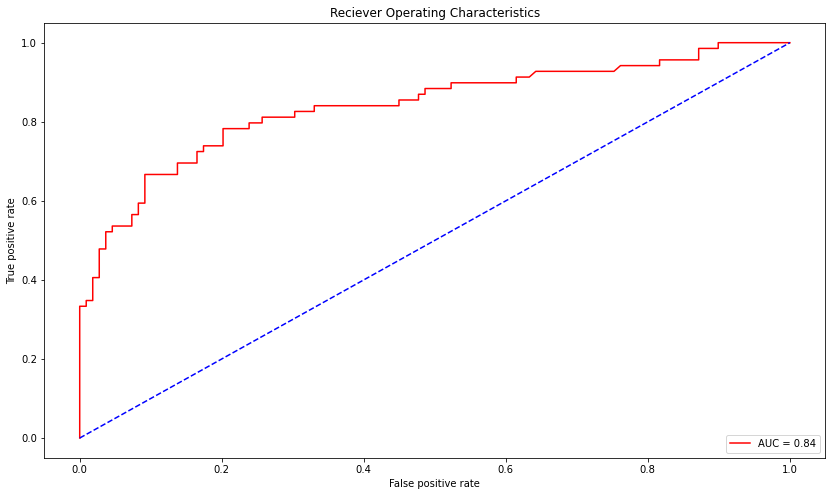

In [24]:
proba = lr.predict_proba(xvl)[:,1]
frp,trp, threshold = roc_curve(yvl,proba)
roc_auc_ = auc(frp,trp)

plt.figure(figsize=(14,8))
plt.title('Reciever Operating Characteristics')
plt.plot(frp,trp,'r',label = 'AUC = %0.2f' % roc_auc_)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')